# **Libraries And Dataset**

In [19]:
# Data visualisation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Random Forest utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, make_scorer, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,MinMaxScaler

In [20]:
dataset = pd.read_csv('data/market_cluster.csv', encoding='latin1')

In [21]:
dataset.head()

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State,profit_margin,Cluster
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu,0.32,Medium
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu,0.20,Medium
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu,0.07,Low
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu,0.10,Low
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu,0.39,High


In [22]:
dataset.describe()

,Sales,Discount,Profit,profit_margin
count,9994.000000,9994.000000,9994.000000,9994.000000
mean,1496.596158,0.226817,374.937082,0.250228
std,577.559036,0.074636,239.932881,0.118919
min,500.000000,0.100000,25.250000,0.050000
25%,1000.000000,0.160000,180.022500,0.150000
50%,1498.000000,0.230000,320.780000,0.250000
75%,1994.750000,0.290000,525.627500,0.350000
max,2500.000000,0.350000,1120.950000,0.450000


# **Data Cleaning & Preprocessing**

In [23]:
dataset.drop(['Order ID'], axis=1, inplace=True)

In [24]:
dataset.isna().sum()

Customer Name    0
Category         0
Sub Category     0
City             0
Order Date       0
Region           0
Sales            0
Discount         0
Profit           0
State            0
profit_margin    0
Cluster          0
dtype: int64

In [25]:
def remove_outliers(data: pd.DataFrame, column: str) -> pd.Series:
    q3, q1 = np.nanpercentile(data[column], [75, 25])
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    data = data[(data[column] > lower_bound) & (data[column] < upper_bound)]

    return data

dataset = remove_outliers(dataset, 'Discount')
dataset = remove_outliers(dataset, 'Sales')
dataset = remove_outliers(dataset, 'Profit')

In [26]:
dataset.head()

,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State,profit_margin,Cluster
0,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu,0.32,Medium
1,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu,0.20,Medium
2,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu,0.07,Low
3,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu,0.10,Low
4,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu,0.39,High


<AxesSubplot:xlabel='Cluster', ylabel='Count'>

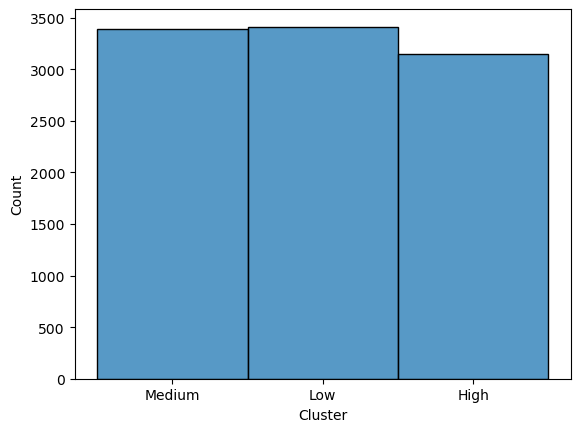

In [27]:
sns.histplot(dataset['Cluster'])

In [28]:
encoder = LabelEncoder()
scaler = StandardScaler()
onehot = OneHotEncoder()
minmaxscaler = MinMaxScaler()

In [29]:
dataset["Order Date"] = pd.to_datetime(dataset["Order Date"])
dataset["Order Date"] = dataset["Order Date"].dt.month

dataset["Customer Name"] = encoder.fit_transform(dataset["Customer Name"])
dataset["Category"] = encoder.fit_transform(dataset["Category"])
dataset["City"] = encoder.fit_transform(dataset["City"])
dataset["Region"] = encoder.fit_transform(dataset["Region"])
dataset["State"] = encoder.fit_transform(dataset["State"])
dataset["Sub Category"] = encoder.fit_transform(dataset["Sub Category"])

# dataset["Customer Name"] = onehot.fit_transform(dataset["Customer Name"].values.reshape(-1, 1)).toarray()
# dataset["Category"] = onehot.fit_transform(dataset["Category"].values.reshape(-1, 1)).toarray()
# dataset["City"] = onehot.fit_transform(dataset["City"].values.reshape(-1, 1)).toarray()
# dataset["Region"] = onehot.fit_transform(dataset["Region"].values.reshape(-1, 1)).toarray()
# dataset["State"] = onehot.fit_transform(dataset["State"].values.reshape(-1, 1)).toarray()
# dataset["Sub Category"] = onehot.fit_transform(dataset["Sub Category"].values.reshape(-1, 1)).toarray()

dataset["Order Date"] = encoder.fit_transform(dataset["Order Date"])

In [30]:
dataset[["Sales", "Discount", "profit_margin","Profit"]] = scaler.fit_transform(dataset[["Sales", "Discount", "profit_margin","Profit"]])

In [31]:
class_to_numeric = {'Low': 0, 'Medium': 1, 'High': 2}
dataset['Cluster'] = [class_to_numeric[label] for label in dataset['Cluster']]

In [32]:
dataset.head()

,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State,profit_margin,Cluster
0,12,5,14,21,10,2,-0.414559,-1.430908,0.124389,0,0.595874,1
1,37,1,13,8,10,3,-1.291968,-0.627370,-0.941183,0,-0.416872,1
2,14,3,0,13,5,4,1.507054,-0.225601,-0.875930,0,-1.514014,0
3,15,4,12,4,9,3,-1.036563,0.310092,-1.196262,0,-1.260827,0
4,28,3,18,12,9,3,1.498367,0.444015,2.315743,0,1.186643,2


# **Data Split**

In [33]:
dataset = dataset.fillna(dataset.mean())

# Check for and handle infinite values
dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.dropna()

In [34]:
X = dataset.drop(['Cluster','Sub Category','State','Profit','profit_margin'],axis=1)
y = dataset['Cluster']

In [35]:
X.head()

,Customer Name,Category,City,Order Date,Region,Sales,Discount
0,12,5,21,10,2,-0.414559,-1.430908
1,37,1,8,10,3,-1.291968,-0.627370
2,14,3,13,5,4,1.507054,-0.225601
3,15,4,4,9,3,-1.036563,0.310092
4,28,3,12,9,3,1.498367,0.444015


In [36]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import LabelEncoder
# tfidf_vectorizer = TfidfVectorizer(max_features=1000) 

# X_text = tfidf_vectorizer.fit_transform(dataset['Category'])

# # Example: Encode categorical features using LabelEncoder
# label_encoder = LabelEncoder()
# X_author = label_encoder.fit_transform(dataset['Profit'])
# X = pd.concat([pd.DataFrame(X_text.toarray()), pd.DataFrame(X_author)], axis=1)

In [37]:
# X = dataset.drop(['If_Profit','Sales','profit_margin'],axis=1)
# X = dataset['Sales']
# y = dataset['If_Profit']

In [38]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify= y) 
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size= 0.2)

# **Random Forest Classifier**

In [39]:
rfc = RandomForestClassifier(random_state=42)

params = { 
    "n_estimators": range(50,350,50), 
    "max_depth": range(5,41,5), 
    "criterion": ["gini", "entropy"]
}

In [40]:
model_rf =  GridSearchCV(estimator=rfc, #
    param_grid=params,
    cv=2, 
    n_jobs=-1,
    verbose=1
)

In [41]:
model_rf.fit(X_train, y_train) # model fit

Fitting 2 folds for each of 96 candidates, totalling 192 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 41, 5),
                         'n_estimators': range(50, 350, 50)},
             verbose=1)

In [42]:
import joblib
joblib.dump(model_rf, 'model/randomforest_model.pkl')

['model/randomforest_model.pkl']

In [43]:
cv_results_rf = pd.DataFrame(model_rf.cv_results_)
cv_results_rf.sort_values("rank_test_score").head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
2,0.800543,0.201584,0.086926,0.035048,gini,5,150,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.343279,0.34956,0.34642,0.003141,1


In [44]:
y_pred = model_rf.predict(X_test)

In [45]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy:.2f}")

Accuracy : 0.35


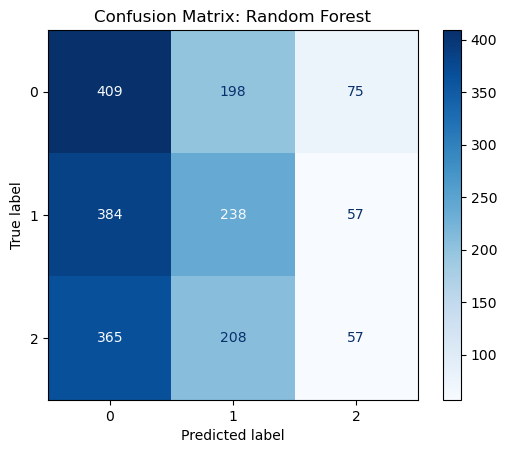

In [46]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Random Forest")
plt.show()

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.35      0.60      0.44       682
           1       0.37      0.35      0.36       679
           2       0.30      0.09      0.14       630

    accuracy                           0.35      1991
   macro avg       0.34      0.35      0.31      1991
weighted avg       0.34      0.35      0.32      1991

